In [1]:
%matplotlib inline

In [2]:
import numpy as np
from load_intan_rhd_format import read_data
import matplotlib.pyplot as plt
import itertools
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
plt.rcParams['axes.xmargin'] = 0

# Read Data from Data Files
Intan saves data in chunks of 60 secs into a data folder. Load the files below. Be careful not to load too many files at a time to avoid long computing times

In [4]:
filenames = ['./Workshop Sample Data/20210721_20210726_210726_141503.rhd',
             './Workshop Sample Data/20210721_20210726_210726_141603.rhd',
             './Workshop Sample Data/20210721_20210726_210726_141703.rhd',
             './Workshop Sample Data/20210721_20210726_210726_141803.rhd',
             './Workshop Sample Data/20210721_20210726_210726_141903.rhd'
            ]

Iterate through each data file, and load the data.

The data from each file will be concatenated, and we generate three variables:
 - `time` vector
 - `data` matrix
 - `sample_rate` scalar

In [5]:
data = [read_data(f) for f in filenames]


Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 7
Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.000 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.5 seconds

Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 7
Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 2 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.000 seconds of data.  Am

In [6]:
time = np.concatenate([d['t_amplifier'] for d in data])
sample_rate = data[0]['frequency_parameters']['amplifier_sample_rate']
data = np.concatenate([d['amplifier_data'] for d in data], axis=1)
n_chans, n_points = data.shape

# Filter and Plot Data
How many channels do you want plotted in each figure? Recommended number is 8 as this matches the number of contacts on each thread and it helps to group channels into manageable axes.

In [7]:
n_chan_per_plot = 8

You can plot data using a few tricks to help filter out unwanted common mode noise. In order to plot data as it is recorded by the amplifier, set this value to `None`. If you want to subtract one channel from ALL OTHER channels, set this variable to a single number corresponding to the channel to subtract from the others. This will treat the specified channel as a "reference." You can also subtract a channel from each of the channels that are plotted within a figure. For example, if you have 32 channels and n_chan_per_plot is set to 8, there will be 4 figures. You can then specify an array with 4 elements such that the first element of the array will be the channel subtracted from the axes in the first figure, the second element in the array will be the channel subtracted from the axes in the second figure, etc.

In [8]:
# chan_subtract = None
# chan_subtract = 7
chan_subtract = [7,15,20,26]

Specify the low cutoff and high cutoff for the bandpass filter.

In [9]:
filt_lo = 350
filt_hi = 7500

create a band pass filter

In [10]:
sos = signal.butter(8, [filt_lo, filt_hi], 'bandpass', fs=sample_rate, output='sos')
filtered_data = data.copy()

Instantiate the figure(s) with specified number of axes, filter data, and plot data on axes.

Figure 0 - channels [0-7] - substract [7]
Figure 1 - channels [8-15] - substract [15]
Figure 2 - channels [16-23] - substract [20]
Figure 3 - channels [24-31] - substract [26]


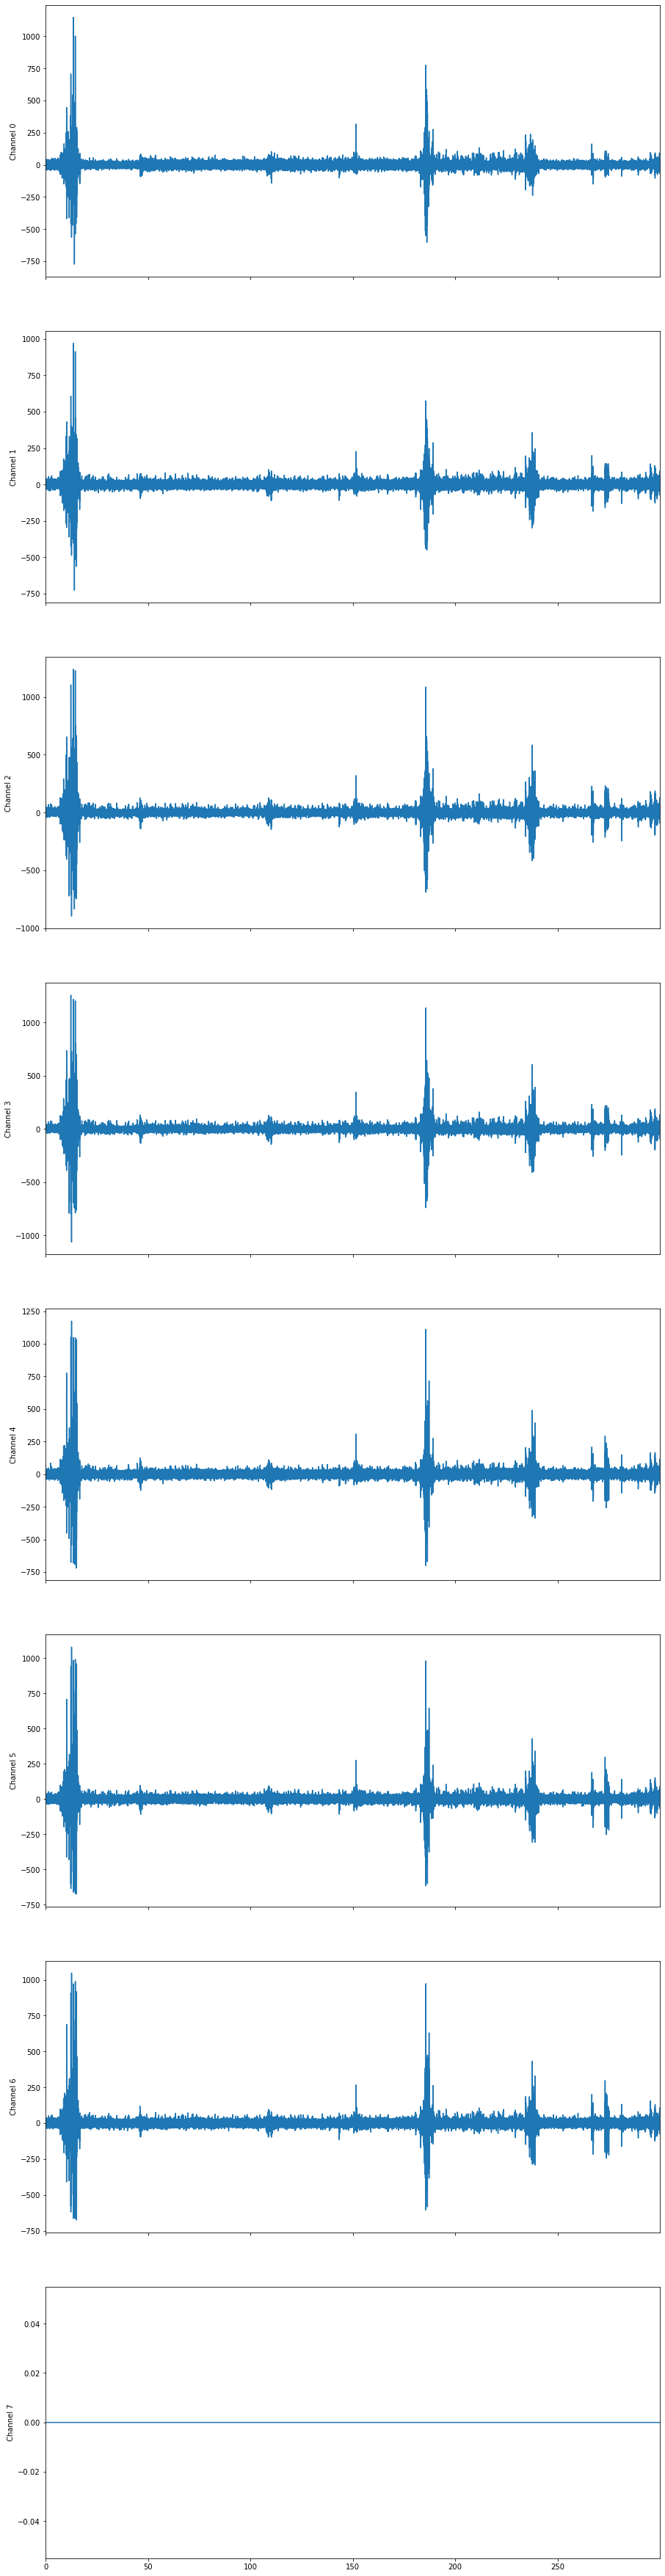

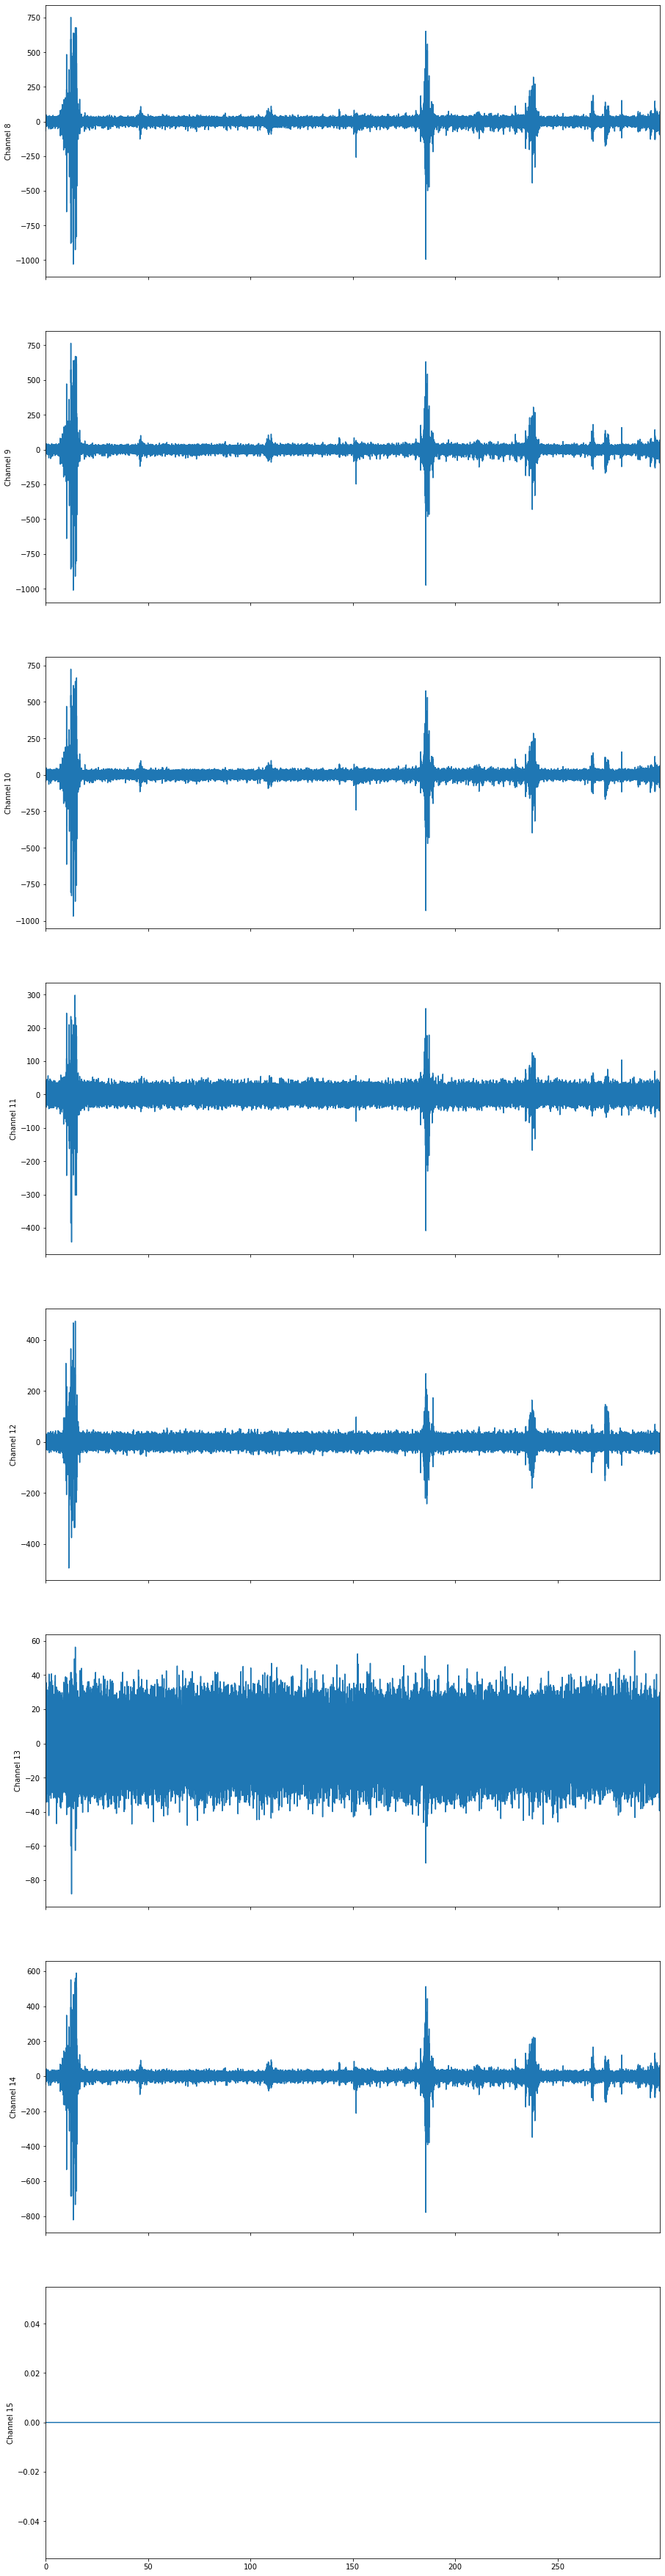

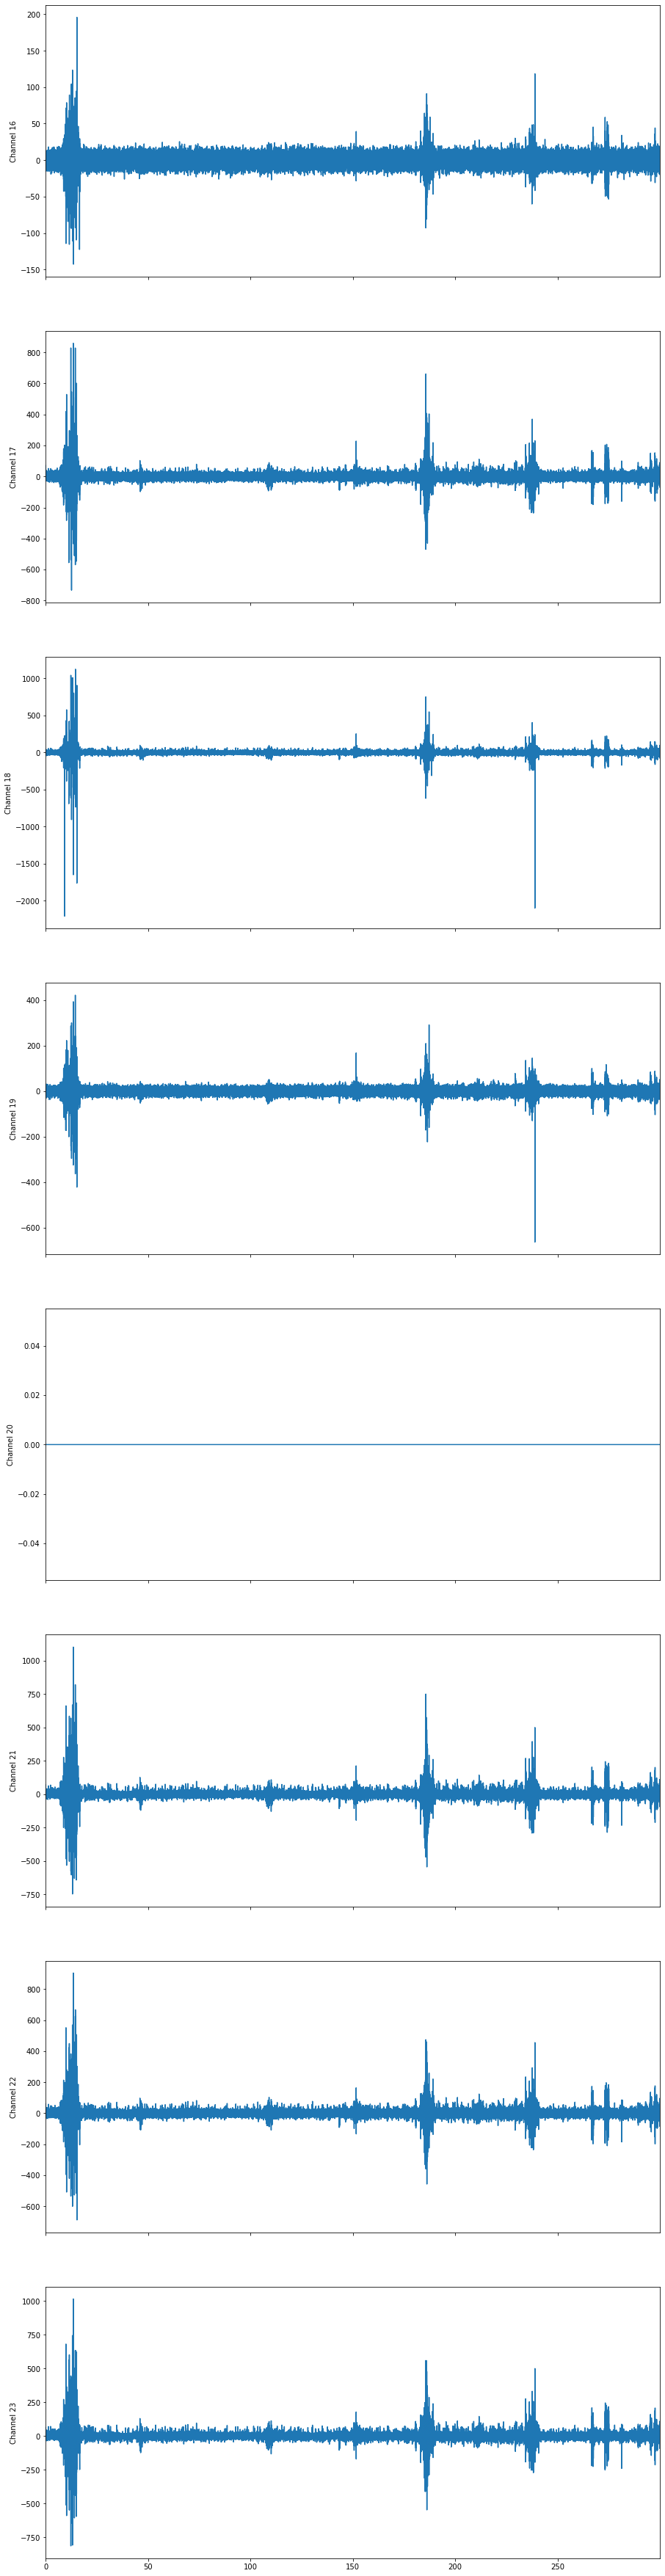

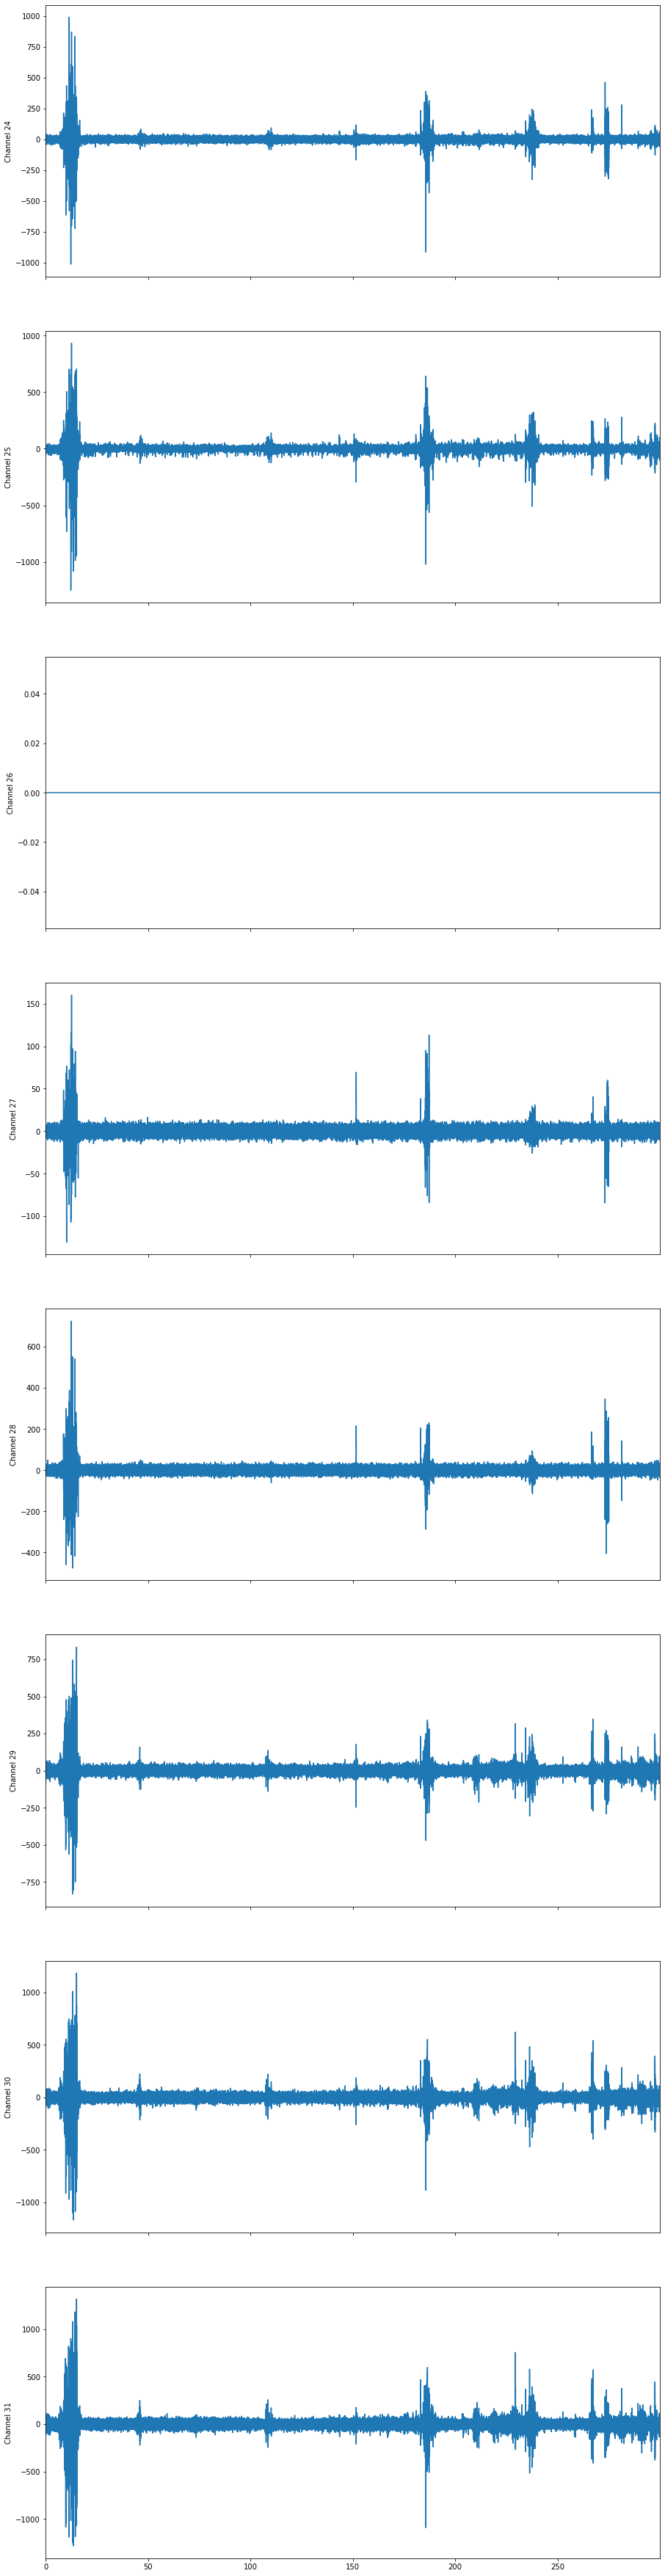

In [11]:
figsize = (15,8)
downsample = 50  # for display purpososes, downsample the traces
n_figures = int(np.ceil(n_chans/n_chan_per_plot))
for i, sub in zip(range(n_figures), itertools.cycle(np.atleast_1d(chan_subtract))):
    print(f'Figure {i} - channels [{i*n_chan_per_plot}-{(i+1)*n_chan_per_plot-1}] - substract [{sub}]')
    fig, axs = plt.subplots(n_chan_per_plot, 1, sharex=True, figsize=np.asarray(figsize)*[1,n_chan_per_plot])
    for ax, chan in zip(axs,range(n_chan_per_plot)):
        chan_idx = i*n_chan_per_plot+chan
        # print(f'Processing channel {i*n_chan_per_plot+chan}')
        if sub is None:
            filtered_datum = signal.sosfiltfilt(sos, data[chan_idx])
        else:
            filtered_datum = signal.sosfiltfilt(sos, data[chan_idx]-data[sub])
        filtered_data[chan_idx] = filtered_datum
        ax.plot(time[::downsample], filtered_datum[::downsample], label=f'Ch{chan_idx}')
        ax.set_ylabel(f'Channel {chan_idx}')

# Detect Spikes and Cluster Waveforms
Specify which channel of filtered data to analyze.

In [12]:
chan_clust = 0

Specify the level of sensitivity for spike detection. The threshold is set using a robust estimator derived for neural activity.

In [13]:
std_th_val = 7

In [14]:
std_th = std_th_val*(np.median(np.abs(filtered_data[chan_clust]))/0.6745)
down_ix, = np.nonzero(np.diff(np.sign(filtered_data[chan_clust]-std_th)) == -2)
up_ix, = np.nonzero(np.diff(np.sign(filtered_data[chan_clust]-std_th)) == 2)

if len(down_ix)>0 and len(up_ix)>0:
    pass
else:
    print("No spikes found!")    

In [15]:
peaks = []
peaks_idx = []
for up_i, down_i in zip(up_ix, down_ix):
    peaks.append(np.max(filtered_data[chan_clust][up_i:down_i]))
    peaks_idx.append(up_i + np.argmax(filtered_data[chan_clust][up_i:down_i]))

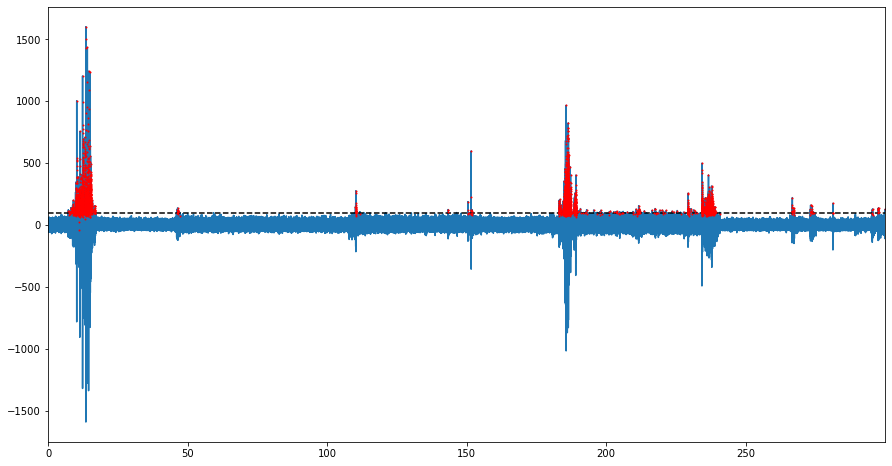

In [16]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(time, filtered_data[chan_clust])
ax.axhline(std_th, ls='--', c='k')
ax.plot(time[peaks_idx], filtered_data[chan_clust][peaks_idx], 'ro', ms=1)

## Clustering

Specify the window duration with which to perform PCA and clustering. Plot sample of waveforms.

In [17]:
spk_win = 5  # ms
wavs_to_plot = 250  # specify number of waveforms to plot for preview
winsize = int(spk_win*1e-3 * sample_rate)  # number of points for each waveform

In [18]:
# Dropping peaks that are too close to the beginning or end of the file
spikes_idx = np.asarray(peaks_idx);
spikes_idx = spikes_idx[np.all([spikes_idx>(winsize//2+1),spikes_idx<(n_points-(winsize//2+1))],axis=0)]
n_wavs = len(spikes_idx) # number of waveforms

# create a matrix [n_wavs x winsize] to align all the spike waveforms
wav_mat = np.zeros(shape=(n_wavs, winsize))
for i,idx in enumerate(spikes_idx):
    wav_mat[i,:] = filtered_data[chan_clust][idx-winsize//2:idx+winsize//2]

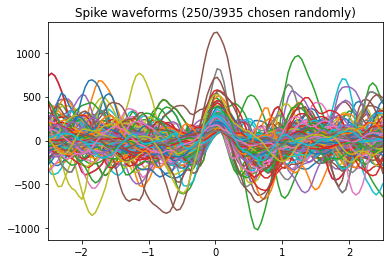

In [19]:
fig, ax = plt.subplots()
ax.set_title(f"Spike waveforms ({wavs_to_plot}/{n_wavs} chosen randomly)")
t = np.linspace(0,spk_win,winsize) - spk_win/2
for i in np.random.randint(0, n_wavs-1, wavs_to_plot):
    ax.plot(t, wav_mat[i])

Specify the number of clusters you'd like to have in the end. Perform PCA decomposition and then cluster using k-means.

In [20]:
n_clust = 5
n_PC = 3

In [21]:
pca = PCA(n_components=n_PC)
X_r = pca.fit(wav_mat).transform(wav_mat)
kmeans = KMeans(n_clusters=n_clust).fit_predict(X_r)

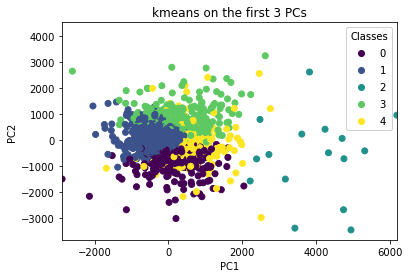

In [22]:
fig, ax = plt.subplots()
s = ax.scatter(X_r[:,0], X_r[:,1], c=kmeans)
l = ax.legend(*s.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(l)
ax.set_title(f'kmeans on the first {n_PC} PCs')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

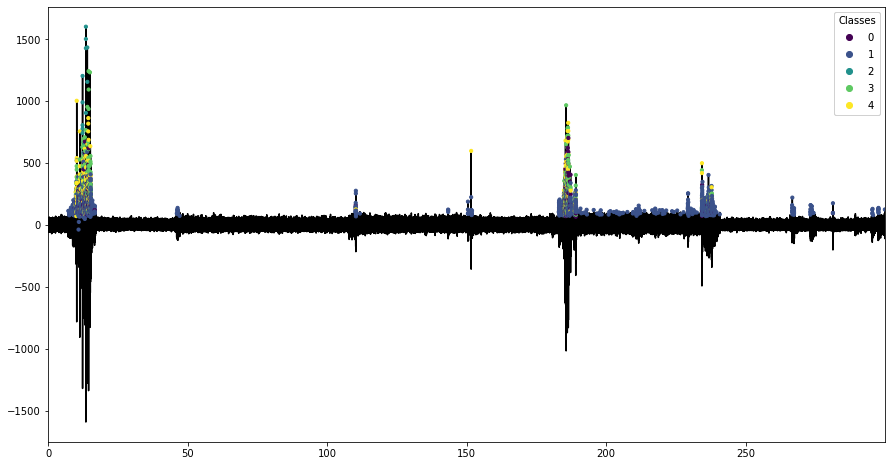

In [31]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(time, filtered_data[chan_clust], c='k', zorder=-1)
s = ax.scatter(time[spikes_idx], filtered_data[chan_clust][spikes_idx], c=kmeans, s=10)
l = ax.legend(*s.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(l)